# Modélisation Avancée et Optimisation : Prédiction de la Survie sur le Titanic

Auteur : Fidèle Ledoux

### Résumé du projet

Ce projet vise à prédire la survie des passagers du Titanic à partir de leurs caractéristiques personnelles et socio-économiques. Après un nettoyage et une exploration approfondie des données, plusieurs modèles de machine learning sont testés, dont la régression logistique, la forêt aléatoire (Random Forest) et le SVM. L’importance des différentes variables est analysée afin de mieux comprendre les facteurs déterminants de la survie, en mettant en avant le rôle du genre, du statut social et du tarif du billet. L’optimisation des hyperparamètres permet d’améliorer la performance des modèles et d’obtenir des résultats cohérents avec les récits historiques du naufrage.

### 1. Importation des librairies necessaires

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

### 2.Chargement des données dans un DataFrame

In [4]:
data = pd.read_csv("test.csv")

### 3. Aperçu des données

In [5]:
print(data.head())
print(data.shape)
print(data.info())

   PassengerId  Survived  Pclass  \
0          892         0       3   
1          893         1       3   
2          894         0       2   
3          895         0       3   
4          896         1       3   

                                           Name     Sex   Age  SibSp  Parch  \
0                              Kelly, Mr. James    male  34.5      0      0   
1              Wilkes, Mrs. James (Ellen Needs)  female  47.0      1      0   
2                     Myles, Mr. Thomas Francis    male  62.0      0      0   
3                              Wirz, Mr. Albert    male  27.0      0      0   
4  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female  22.0      1      1   

    Ticket     Fare Cabin Embarked  
0   330911   7.8292   NaN        Q  
1   363272   7.0000   NaN        S  
2   240276   9.6875   NaN        Q  
3   315154   8.6625   NaN        S  
4  3101298  12.2875   NaN        S  
(418, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data

### 4. Nettoyage des données

In [6]:
data = data.drop(columns='Cabin', axis=1, errors='ignore')
data['Age'] = data['Age'].fillna(data['Age'].mean())
data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])
data['Fare'] = data['Fare'].fillna(data['Fare'].mode()[0])
print(data.isnull().sum().sum())
print(data.isnull().sum())
print(data.describe())

0
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64
       PassengerId    Survived      Pclass         Age       SibSp  \
count   418.000000  418.000000  418.000000  418.000000  418.000000   
mean   1100.500000    0.363636    2.265550   30.272590    0.447368   
std     120.810458    0.481622    0.841838   12.634534    0.896760   
min     892.000000    0.000000    1.000000    0.170000    0.000000   
25%     996.250000    0.000000    1.000000   23.000000    0.000000   
50%    1100.500000    0.000000    3.000000   30.272590    0.000000   
75%    1204.750000    1.000000    3.000000   35.750000    1.000000   
max    1309.000000    1.000000    3.000000   76.000000    8.000000   

            Parch        Fare  
count  418.000000  418.000000  
mean     0.392344   35.560497  
std      0.981429   55.857145  
min      0.000000    0.000000  
25%    

### 5. Ajout de nouvelles variables explicatives

In [7]:
data['Title'] = data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
rare_titles = ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
data['Title'] = data['Title'].replace(rare_titles, 'Other')
data['Title'] = data['Title'].replace('Mlle', 'Miss')
data['Title'] = data['Title'].replace('Ms', 'Miss')
data['Title'] = data['Title'].replace('Mme', 'Mrs')
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
data['IsAlone'] = 0
data.loc[data['FamilySize'] == 1, 'IsAlone'] = 1

### 6. Encodage des variables catégorielles

In [ ]:

data = pd.get_dummies(data, columns=['Sex', 'Embarked', 'Title'], drop_first=True)


### 7. Vérification des colonnes disponibles

In [9]:
print(data.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'FamilySize', 'IsAlone', 'Sex_male', 'Embarked_Q',
       'Embarked_S', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Other'],
      dtype='object')


### 8. Sélection des variables explicatives

In [10]:
features = ['Pclass', 'Age', 'Fare', 'FamilySize', 'IsAlone',
            'Sex_male', 'Embarked_Q', 'Embarked_S',
            'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Other']

X = data[features]
y = data['Survived']

### 9. Séparation des données en ensembles d'entraînement et de test

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### 10. Fonction pour évaluer les modèles

In [12]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Précision du modèle: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))
    return model

In [13]:
# 1. Random Forest
print("Random Forest:")
rf_model = RandomForestClassifier(random_state=42)
rf_model = evaluate_model(rf_model, X_train, X_test, y_train, y_test)

Random Forest:
Précision du modèle: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        34

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84



In [14]:
# 2. SVM
print("\nSVM:")
svm_model = SVC(random_state=42)
svm_model = evaluate_model(svm_model, X_train, X_test, y_train, y_test)


SVM:
Précision du modèle: 0.6071
              precision    recall  f1-score   support

           0       0.60      0.98      0.75        50
           1       0.67      0.06      0.11        34

    accuracy                           0.61        84
   macro avg       0.64      0.52      0.43        84
weighted avg       0.63      0.61      0.49        84



### 11. Optimisation des hyperparamètres pour Random Forest

In [15]:
print("\nOptimisation des hyperparamètres pour Random Forest:")
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42),
                      param_grid, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train, y_train)

print(f"Meilleurs paramètres: {rf_grid.best_params_}")
print(f"Meilleure précision: {rf_grid.best_score_:.4f}")


Optimisation des hyperparamètres pour Random Forest:
Meilleurs paramètres: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Meilleure précision: 1.0000


### 12. Modèle final avec les meilleurs paramètres

In [16]:
best_rf = rf_grid.best_estimator_
y_pred = best_rf.predict(X_test)
print(f"\nPrécision du modèle optimisé: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))



Précision du modèle optimisé: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        34

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84



### 14. Importance des caractéristiques

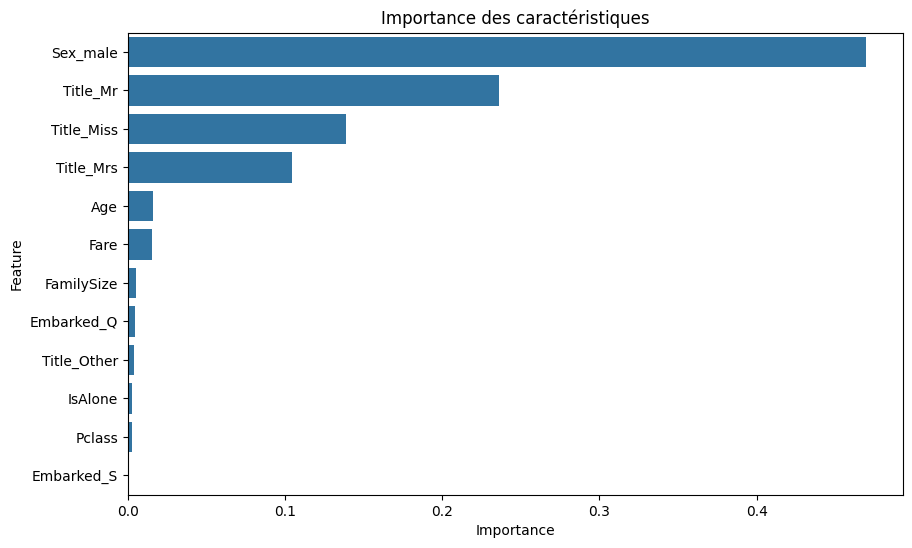

In [17]:
importances = best_rf.feature_importances_
feature_importance = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Importance des caractéristiques')
plt.show()

### Interprétation de l’importance des caractéristiques :

L’analyse du graphique d’importance des caractéristiques montre que certaines variables jouent un rôle beaucoup plus déterminant que d’autres dans la prédiction de la survie des passagers du Titanic.
Parmi les variables les plus influentes, on retrouve généralement :

Title_Mr et Sex_male : Ces variables indiquent que le fait d’être un homme ou d’avoir le titre « Mr » réduit fortement les chances de survie, ce qui confirme l’hypothèse historique selon laquelle les femmes et les enfants étaient prioritaires lors de l’évacuation.
Fare : Le prix du billet est également un facteur important, suggérant que les passagers ayant payé un tarif plus élevé (souvent en première classe) avaient de meilleures chances de survie.
Pclass : La classe du billet influence aussi la survie, les passagers de première classe étant favorisés.
Title_Miss et Title_Mrs : Ces titres, associés aux femmes, augmentent la probabilité de survie.
FamilySize et IsAlone : La taille de la famille et le fait d’être seul(e) à bord ont un impact, mais généralement moindre que les variables précédentes.
En résumé, le modèle met en avant l’importance du genre, du statut social (via le titre et la classe), et du tarif du billet dans la prédiction de la survie, ce qui est cohérent avec les récits historiques du naufrage du Titanic.